In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
plt.style.use('ggplot')

In [2]:
def load_data(path, csv_file_name):
    if not csv_file_name.endswith('.csv'):
        csv_file_name = ''.join([csv_file_name, '.csv'])
    file_path = os.path.join(path, csv_file_name)
    return pd.read_csv(file_path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_ts(df, rolling_period, resample_period=1):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    df = df.resample('s').count()
    if rolling_period:
        df = df.rolling(rolling_period).mean()
    return df

def calculate_neuron_mfr(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs *= 10**10
    return mfrs


def get_baseline_stats(df, condition_label, resample_period):
    df = df[df['condition'] == condition_label]
    df = create_ts(df=df,
                   rolling_period=False,
                   resample_period=resample_period)
    condition_means = df.transpose().mean(axis=1)
    condition_stds = df.transpose().std(axis=1)
    condition_sorted = condition_means.sort_values()
    return condition_means, condition_stds, condition_sorted


def normalise(df, method, condition_means, condition_stds, condition_sorted):
    if method == 'zscore':
        def f(col):
            return (col.subtract(condition_means)).divide(condition_stds)
    elif method == 'percent':
        def f(col):
            return col.divide(condition_means) * 100
    elif not method:
        def f(col):
            print('Note: No Normalisation Method Provided')
            return col
    df = df.transpose().apply(f)
    return df.reindex(condition_sorted.index)


def select_neruon_cat(ts_df, df_all_neurons, recording, category_column, category):
    clusters = df_all_neurons[(df_all_neurons['recording'] == recording) & (df_all_neurons[category_column] == category)]['spike_cluster'].unique()
    return ts_df[ts_df.index.isin(clusters)]


def plot_heatmap_separate_categories(ts_df, df_all_neurons, recording, category_column, vmin, vmax, normalise_method, out_folder):

    num_categories = len(df_all_neurons['category'].unique())
    f, a = plt.subplots(nrows=num_categories, ncols=1, figsize=(19, 25))

    for index, category in enumerate(df_all_neurons[category_column].unique()):
        df_cat = select_neruon_cat(ts_df=ts_df,
                                   df_all_neurons=df_all_neurons,
                                   recording=recording,
                                   category_column=category_column,
                                   category=category)

        recording_len = df_cat.transpose().index.max().seconds
        x_tick_pos = round(recording_len / 4)

        sns.heatmap(data=df_cat,
                    cmap='coolwarm',
                    vmin=vmin,
                    vmax=vmax,
                    ax=a.flat[index],
                    xticklabels=x_tick_pos,
                    cbar_kws={'label': f'{normalise_method} Baseline mean'})

        a.flat[index].set_xticklabels(list(map(lambda num:
                                               str(round(recording_len / 4 / 60 * num, -1)),
                                               [0, 1, 2, 3])))
        a.flat[index].set_title(category)
    plt.suptitle(recording, fontsize=15)
    plt.tight_layout()
    plt.savefig(gen_fig_path(out_folder, recording))
    
def find_category(df_rec):
    library = {}
    for cluster in df_rec.spike_cluster.unique():
        library[(cluster)] = df_rec[df_rec['spike_cluster']==cluster]['category'].unique()[0]
    return library


def gen_fig_path(out_folder, recording):
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    return ''.join([os.path.join(out_folder, recording), '.png'])


In [3]:
font = {'fontname':'Calibri'}
csv_dir = r'F:\CIT_WAY\csvs'
csv_file_name = 'all_neurons_ts_with_clusters'
resample_period = '5sec'
rolling_periods=120
normalisation_method = 'percent'
vmin=0
vmax=200
color_list = ['#0392cf','#ee4035', '#7bc043', '#FFFF00']   ###Modify the values here to change the label colors

In [4]:
df_all_data = load_data(path=csv_dir,
                            csv_file_name=csv_file_name)

### Make the index sorted by firing category

In [5]:
df_rec = manipulate_df(df=df_all_data)

In [6]:
cutoff = pd.Timedelta('25 minutes')

In [7]:
df_rec= df_rec[df_rec['time']>=cutoff]

In [8]:
def modify_category(df):
    if df == 'fast regular':
        return 'Fast Firing'
    elif df == 'slow regular':
        return 'Slow Regular'
    elif df == 'slow irregular':
        return 'Slow Irregular'

df_rec['category'] = df_rec['category'].apply(modify_category)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
heatmap_index = []
category_reminder = {}
for category in df_rec['category'].unique():
    one_type = df_rec[df_rec['category']==category]['spike_cluster'].unique().tolist()
    heatmap_index.extend(one_type)
    category_reminder[category] = one_type

### Back to generating data for the heatmap

In [10]:
base_means, base_stds, base_sorted = get_baseline_stats(df=df_rec,
                                                                condition_label='Baseline',
                                                                resample_period=resample_period)

df_ts = create_ts(df=df_rec,
                           resample_period=resample_period,
                           rolling_period=rolling_periods)

df_ts = normalise(df=df_ts,
                           method=normalisation_method,
                           condition_means=base_means,
                           condition_stds=base_stds,
                           condition_sorted=base_sorted)

In [11]:
max_time = df_rec['time'].max()
maxtime = max_time.total_seconds()/60

### Make color labels for clustermap

In [12]:
df_ts = df_ts.fillna(value=0)
df_ts = df_ts.reindex(index=heatmap_index)

#### First, make a library of  each cluster and its corresponding category

In [13]:
catergories_dict = find_category(df_rec)

In [14]:
categories = pd.Series(catergories_dict)

In [15]:
colors = pd.Series(catergories_dict).apply(lambda x: color_list[0] if x == 'Slow Regular' else color_list[1] if x == 'Slow Irregular' else color_list[2] if x == 'Fast Firing' else color_list[3])

In [16]:
df_colors = pd.concat([categories, colors], axis=1)
df_colors.columns = ['category', 'color']

#### Map that to the index (just to make sure the order is right) and then re-assign the categories as colors

In [45]:
tick_labels = np.arange(-35, maxtime, 17.5)

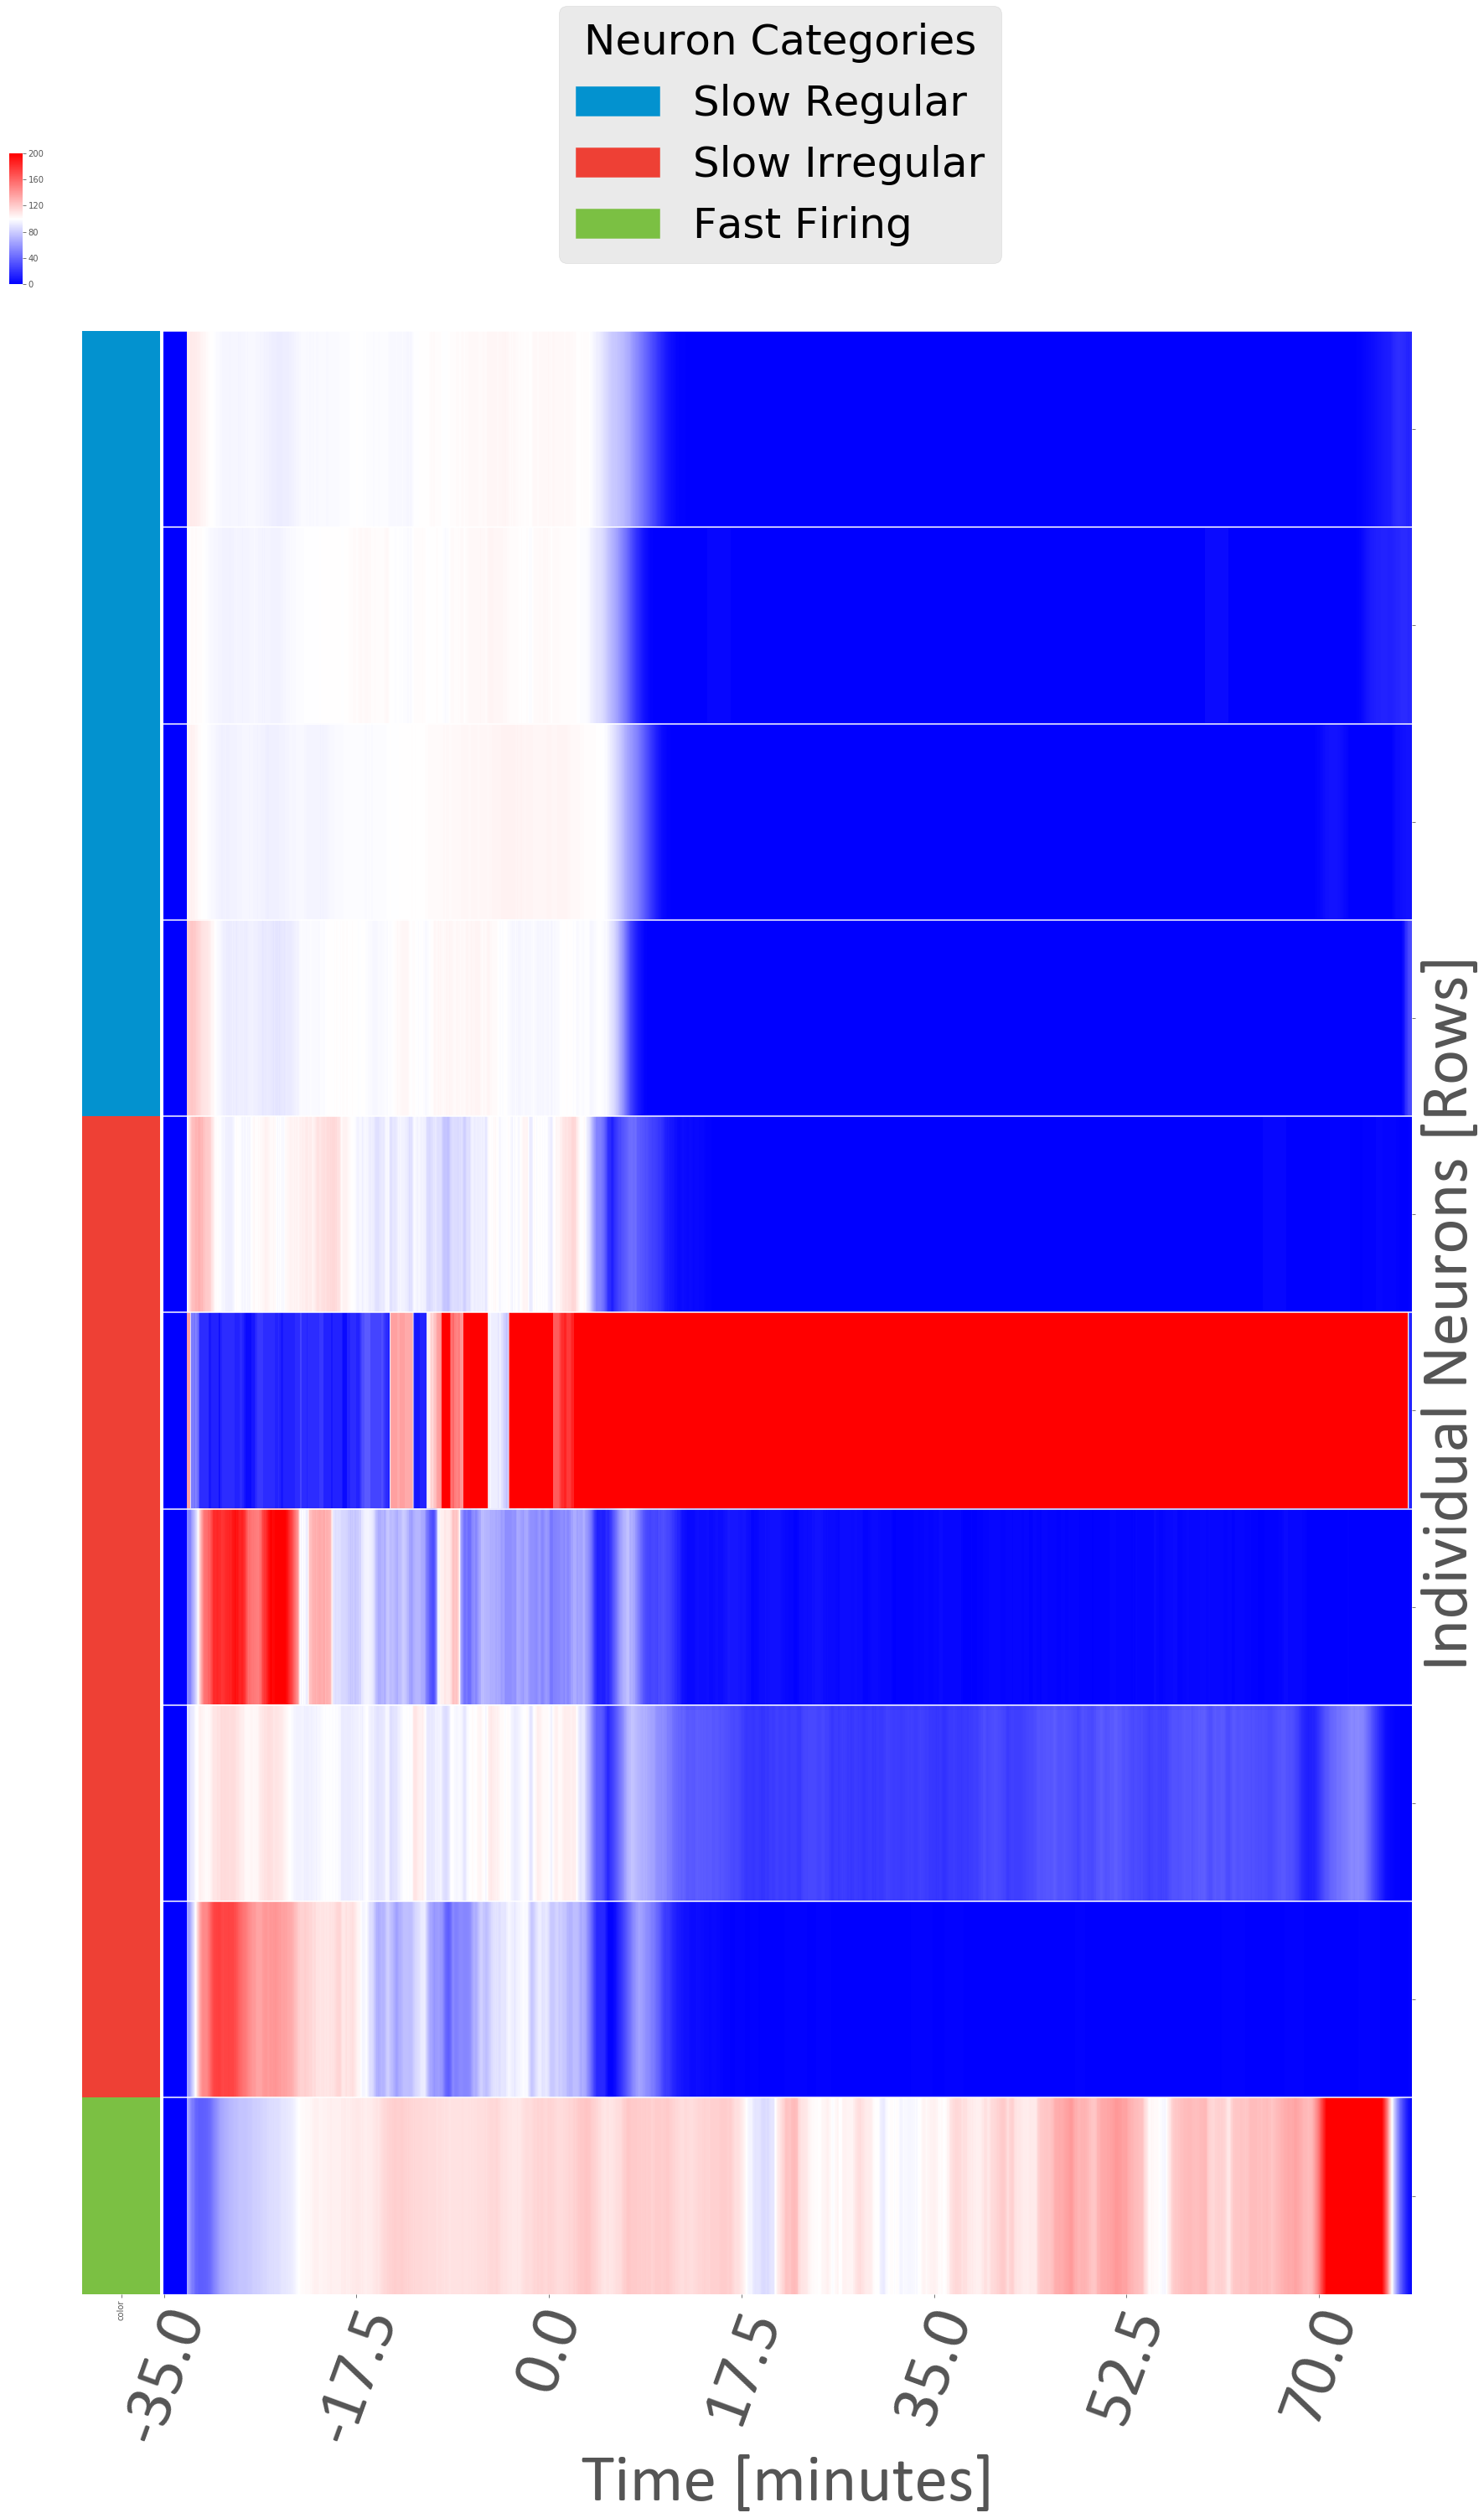

In [48]:
recording_len = df_ts.transpose().index.max().seconds
x_tick_pos = round(recording_len / 8)

cm =sns.clustermap(data=df_ts, cmap='bwr', vmin=vmin, vmax=vmax, row_colors = df_colors.drop('category', axis=1), xticklabels=x_tick_pos, row_cluster= False, col_cluster=False, figsize=(30,47))
patches = []
for color in ['#0392cf','#ee4035', '#7bc043']:
    patch = mpatches.Patch(color=color, label=df_colors[df_colors['color']==color]['category'].iloc[0])
    patches.append(patch)
    
legends=cm.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.3, 1.1),handles=patches,frameon=True, markerscale=10, prop={'size': 50})
legends.set_title(title='Neuron Categories',prop={'size':50})

for line in np.arange(0,df_ts.shape[0],1):
    cm.ax_heatmap.axhline(line, color='w')
cm.ax_heatmap.set_xticklabels(tick_labels, **font, fontsize=80, rotation=70)

#cm.ax_heatmap.set_xticks(pd.to_numeric(ticks), tick_labels)

cm.ax_heatmap.set_xlabel('Time [minutes]', **font, fontsize=80)
cm.ax_heatmap.set_ylabel('Individual Neurons [Rows]', **font, fontsize=80)
cm.ax_heatmap.set_yticklabels([], fontsize=50)
plt.tight_layout
plt.savefig(r'C:\Users\ASUS\Desktop\Images\Heatmap\Heatmap.png', dpi=600)

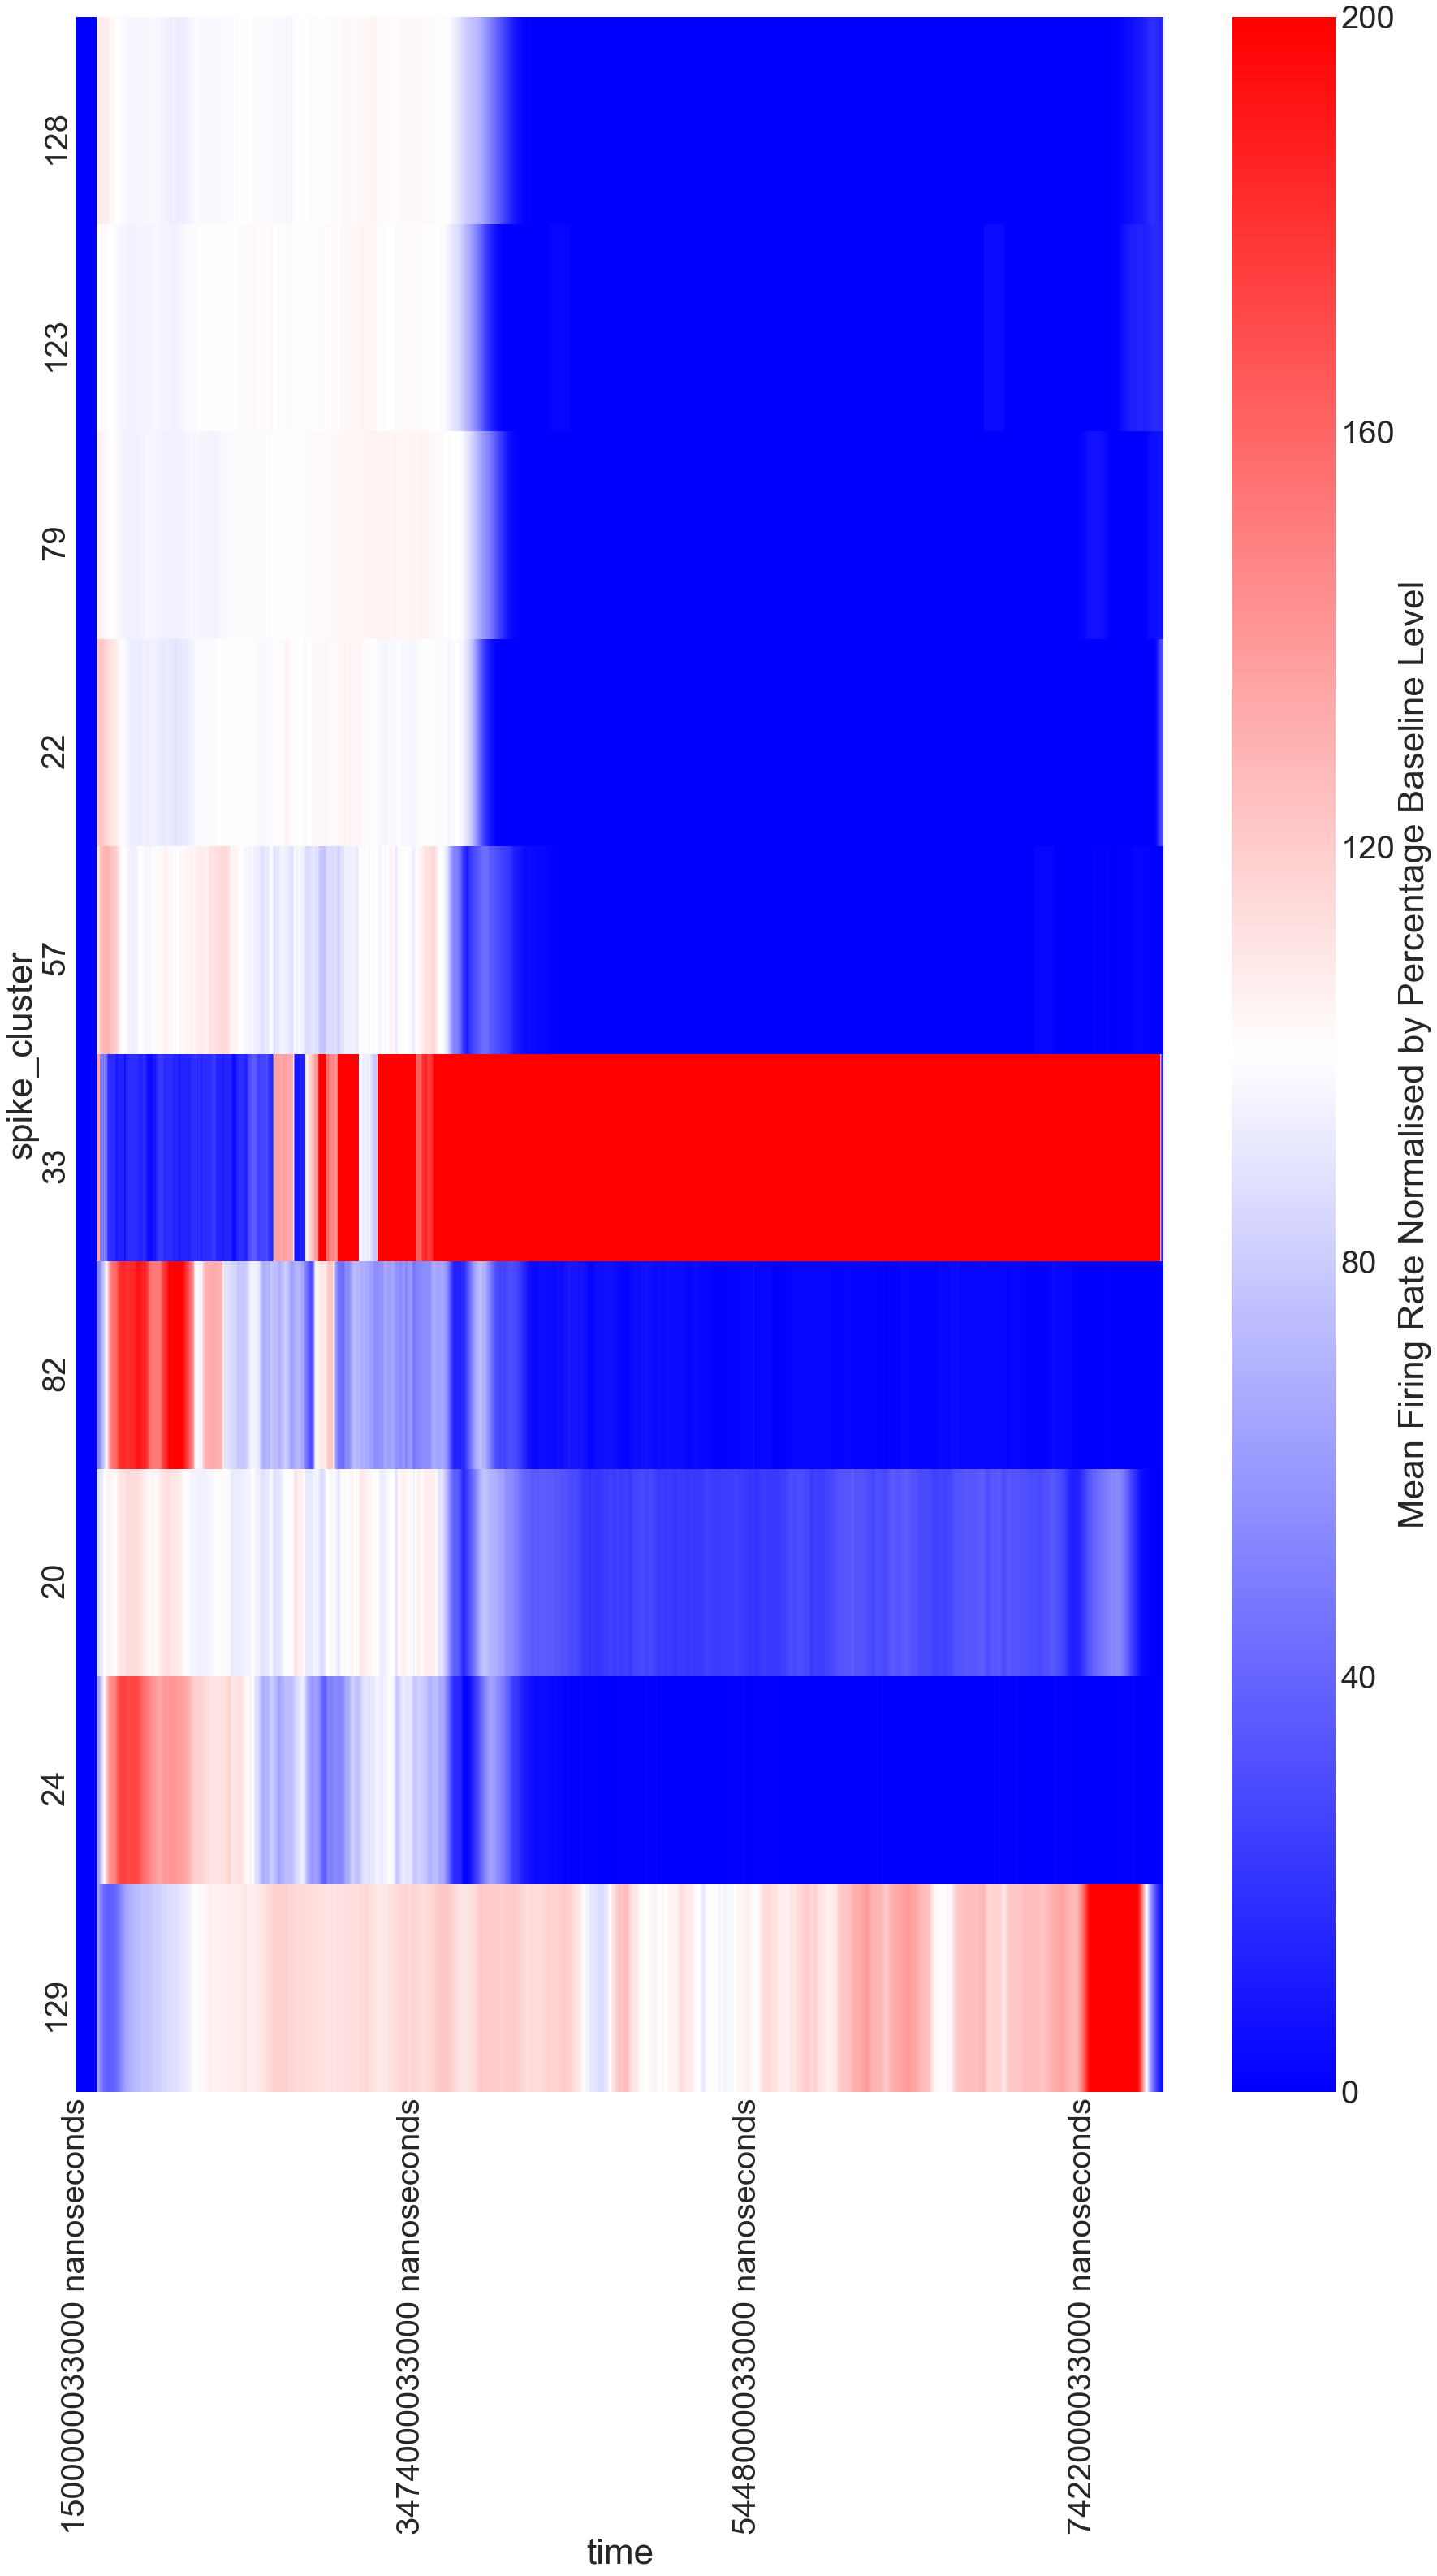

In [42]:
sns.set(font_scale=4)
plt.figure(figsize=(30,47))
ax = sns.heatmap(data=df_ts, cmap='bwr', vmin=vmin, vmax=vmax, xticklabels=x_tick_pos, cbar_kws={'label':'Mean Firing Rate Normalised by Percentage Baseline Level'})

plt.tight_layout
plt.savefig(r'C:\Users\ASUS\Desktop\Images\Heatmap\Heatmap 2.png', dpi=600)